In [1]:
# Standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Tensorflow dependencies
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Embedding

In [4]:
# Print the versions
print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)

TensorFlow version: 2.1.0
OpenCV version: 3.4.2


In [3]:
# GPU Memory Consumption Growth to Avoid OOM errors 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Working directories
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# creating the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [5]:
# uuid library to generate unique image names
import uuid
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\b2c158a4-0133-11ef-a643-80e82c734087.jpg'

In [6]:
# Webcam capture
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

KeyboardInterrupt: 

3. Load and Preprocess Images

3.1 Get Image Directories

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

3.2 Preprocessing - Scale and Resize

In [8]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

3.3 Create Labelled Dataset

!pip uninstall tensorflow-estimator -y
!pip install tensorflow-estimator==2.1.0

In [9]:
# Find the length of the anchor dataset
num_samples = 0
for _ in anchor:
    num_samples += 1

# Create datasets with ones and zeros of the determined length
ones_dataset = tf.data.Dataset.from_tensor_slices(tf.ones(num_samples))
zeros_dataset = tf.data.Dataset.from_tensor_slices(tf.zeros(num_samples))

# Zip and concantenane
positives = tf.data.Dataset.zip((anchor, positive, ones_dataset))
negatives = tf.data.Dataset.zip((anchor, negative, zeros_dataset))

data = positives.concatenate(negatives)

In [10]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

3.4 Build Train and Test Partition

In [11]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [12]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

# Training partition
train_data = data.take(420)
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = data.skip(420)
test_data = test_data.take(180)
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

4. Model Engineering

4.1 Build Embedding Layer

In [13]:
def make_embedding(): 
    # input layer
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First convolution + max layer
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second convolution + max layer
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third convolution + max layer
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [14]:
embedding = make_embedding()

In [15]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

4.2 Build Distance Layer

In [16]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

4.3 Make Siamese Model

In [17]:
#Anchor image
input_image = Input(name='input_img', shape=(100,100,3))

#validation image 
validation_image = Input(name='validation_img', shape=(100,100,3))

In [18]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [19]:
def make_siamese_model(): 
    
    # Anchor image input 
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combining siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Siamese')

In [20]:
siamese_model = make_siamese_model()

In [21]:
siamese_model.summary()

Model: "Siamese"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Model)               (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[3][0]            

5. Training

5.1 Setup Loss and Optimizer

In [22]:
#loss function
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [23]:
#optimizer to minimize loss function
opt = tf.keras.optimizers.Adam(1e-4) # a learning rate of 0.0001

5.2 Establish Checkpoints

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

5.3 Build Train Step Function

In [25]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

5.4 Build Training Loop

In [26]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [27]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Initialize counter for number of batches
        num_batches = 0
        
        # Loop through each batch
        for batch in data:
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            
            # Ensure compatibility of shapes
            y_true = tf.reshape(batch[2], (-1,))  # Ensure y_true has shape (batch_size,)
            yhat = tf.reshape(yhat, (-1,))         # Ensure yhat has shape (batch_size,)
            
            r.update_state(y_true, yhat)
            p.update_state(y_true, yhat) 
            
            # Update number of batches
            num_batches += 1
            
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

5.5 Train the model

EPOCHS = 50

train(train_data, EPOCHS)

6. Evaluate Model

6.1 Import Metrics

In [28]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

6.2 Make Predictions

In [29]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [30]:
y_hat = siamese_model.predict([test_input, test_val])

In [31]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0]

6.3 Calculate Metrics

In [32]:
# Reshape y_true to have the same shape as y_pred
y_true = tf.reshape(y_true, (-1,))

# Post-process y_hat to convert probabilities to binary predictions
y_pred_binary = [1 if prediction > 0.5 else 0 for prediction in y_hat]

# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_pred_binary)

# Return Recall Result
recall_result = m.result().numpy()

# Output Precision Result
print("Recall:", recall_result)

Recall: 0.375


In [33]:
# Reshape y_true to have the same shape as y_pred
y_true = tf.reshape(y_true, (-1,))

# Post-process y_hat to convert probabilities to binary predictions
y_pred_binary = [1 if prediction > 0.5 else 0 for prediction in y_hat]

# Creating a metric object
m = Precision()

# Calculating the precision value
m.update_state(y_true, y_pred_binary)

# Return Precision Result
precision_result = m.result().numpy()

# Output Precision Result
print("Precision:", precision_result)

Precision: 0.42857143


In [34]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])

    # Reshape y_true to have the same shape as yhat
    y_true = tf.reshape(y_true, (-1,))
    yhat = tf.reshape(yhat, (-1,))

    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)

print(r.result().numpy(), p.result().numpy())

0.45544556 0.5609756


6.4 Visualize Results

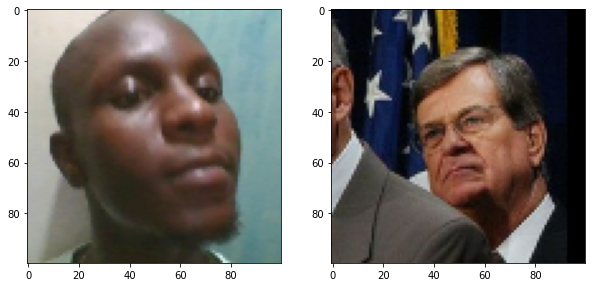

In [35]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
#The Subplot function allows you to render plots using agrid like format.
#The parameters are the number of rows, the number of comlumns, and the index.
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

7. Save Model

In [ ]:
# Save weights
siamese_model.save('siamesemodelfinal.h5')

In [36]:
L1Dist

__main__.L1Dist

In [ ]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelfinal.h5', custom_objects={'L1Dist':L1Dist})
                                  # custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Ken\anaconda3\envs\Face2\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-92343ff66f09>", line 3, in <module>
    siamese_model = load_model('siamesemodelfinal.h5')
  File "C:\Users\Ken\anaconda3\envs\Face2\lib\site-packages\tensorflow_core\python\keras\saving\save.py", line 146, in load_model
    return hdf5_format.load_model_from_hdf5(filepath, custom_objects, compile)
  File "C:\Users\Ken\anaconda3\envs\Face2\lib\site-packages\tensorflow_core\python\keras\saving\hdf5_format.py", line 168, in load_model_from_hdf5
    custom_objects=custom_objects)
  File "C:\Users\Ken\anaconda3\envs\Face2\lib\site-packages\tensorflow_core\python\keras\saving\model_config.py", line 55, in model_from_config
    return deserialize(config, custom_objects=custom_objects)
  File "C:\Users\Ken\anaconda3\envs\Face2\lib\site-packages\tensorflow_core\pyth

TypeError: object of type 'NoneType' has no len()

In [38]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[0.5004282 ],
       [0.5004155 ],
       [0.50074375],
       [0.49956056]], dtype=float32)

In [39]:
# View model summary
siamese_model.summary()

Model: "Siamese"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Model)               (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[3][0]            

8. Real Time Test

8.1 Verification Function

In [41]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('live_data', 'verification_images')):
        input_img = preprocess(os.path.join('live_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('live_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('live_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

8.2 OpenCV Real Time Verification

In [43]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('live_data', 'input_images', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
False
True
True
